# Looking for suitable INTEGRAL targets in the LoVoCCS sample

## Import Statements

In [1]:
from astropy.units import Quantity
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astroquery.skyview import SkyView
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import os
from tqdm import tqdm
from urllib.error import HTTPError
from matplotlib import pyplot as plt
import warnings

from xga.products import Image
from xga.imagetools.misc import physical_rad_to_pix
from xga.sourcetools.misc import rad_to_ang

%matplotlib inline
warnings.filterwarnings('ignore')

## Define useful variables and functions

In [15]:
ibis_det = ["LoVoCCS-8", "LoVoCCS-10", "LoVoCCS-64"]
abell_names = ["A3266", 'A754', "A1736"]

def radio_coverage(samp_df, desc):
    tar_sur = ['GLEAM 139-170 MHz', 'SUMSS 843 MHz', 'NVSS', 'TGSS ADR1']

    if not os.path.exists('skyview_cutouts/'):
        os.makedirs('skyview_cutouts/')

    if not os.path.exists('radio_visualisations/'):
        os.makedirs('radio_visualisations/')
        
    with tqdm(desc=desc, total=len(samp_df)) as onwards:
        for row_ind, row in samp_df.iterrows():
            ims = {ts: None for ts in tar_sur}

            coord_str = str(row['ra']) + ' ' + str(row['dec'])

            if not os.path.exists('skyview_cutouts/{n}'.format(n=row['LoVoCCS_name'])):
                os.makedirs('skyview_cutouts/{n}'.format(n=row['LoVoCCS_name']))

            for ts in tar_sur:
                im_path = 'skyview_cutouts/{n}/{ts}_im.fits'.format(n=row['LoVoCCS_name'], ts=ts.replace(' ', ''))
                if os.path.exists(im_path):
                    ims[ts] = im_path
                    continue

                try:
                    ang_rad = rad_to_ang(Quantity(row['R500'], 'Mpc'), row['redshift'], cosmo)
                    im = SkyView.get_images(coord_str, ts, radius=ang_rad)
                    im[0].writeto(im_path)
                    im[0].close()
                    ims[ts] = im_path
                except Exception as err:
#                     onwards.write(str(err))
                    pass

            fig, ax_arr = plt.subplots(2, 2, figsize=(10, 10))
            ax_arr = ax_arr.flatten()

            for ts_ind, ts in enumerate(ims):
                cur_ax = ax_arr[ts_ind]
                if ims[ts] is not None:

                    cur_im = Image(ims[ts],  '', ts, '', '', '', 
                                   Quantity(np.NaN, 'MHz').to(u.eV, equivalencies=u.spectral()), 
                                   Quantity(np.NaN, 'MHz').to(u.eV, equivalencies=u.spectral()))
                    cur_im.src_name = row['LoVoCCS_name']
                    for rec in cur_im.header.records():                    
                        if 'Bandpass' in list(rec.values())[0] and 'MHz' not in cur_im.instrument :
                            band_str = list(rec.values())[0]
                            cur_im._inst += (" " + band_str.split(':')[-1].replace(' ', ''))

                    cur_im.get_view(cur_ax, Quantity(row[['ra', 'dec']], 'deg'))

                else:
                    cur_ax.tick_params(which='both', left=False, bottom=False)
                    cur_ax.set_xticks([])
                    cur_ax.set_yticks([])
                    cur_ax.set_title(ts, fontsize=14)

            plt.tight_layout()
            plt.savefig('radio_visualisations/{}.png'.format(row['LoVoCCS_name']))
            plt.show()
            plt.close('all')
            onwards.update(1)

## Define cosmology

In [3]:
cosmo = FlatLambdaCDM(70, 0.3)

## Reading in sample files

In [4]:
samp = pd.read_csv("../../sample_files/lovoccs_southnorth.csv")
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))

check = pd.read_csv("../../sample_files/lovoccs_checklist_lite.csv")
check['Name'] = check['Name'].apply(lambda x: x.replace('RXC ', 'RXC').replace("RBS ", "RBS")
                                    .replace("APMCC ", "APMCC").replace("MKW ", "MKW"))


In [5]:
on_other = pd.merge(samp, check, left_on="other_names", right_on="Name", how="right")
on_alt = pd.merge(samp, check, left_on="alt_name", right_on="Name", how="right")
rel_samp = pd.concat([on_other[~on_other['LoVoCCSID'].isna()], 
                      on_alt[~on_alt['LoVoCCSID'].isna()]]).drop_duplicates('LoVoCCSID')
rel_samp['LoVoCCSID'] = rel_samp['LoVoCCSID'].astype(int)
rel_samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,ID,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments
0,MCXCJ1510.9+0543,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN,south,LoVoCCS-1,1,A2029,227.73,5.72,0.0766,1.0,yes,"with A2033, southern infalling group"
1,MCXCJ0258.9+1334,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L,south,LoVoCCS-2,2,A401,44.74,13.58,0.0739,1.0,yes,Bridge of galaxies between A401/A399 -- simila...
2,MCXCJ0041.8-0918,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr",south,LoVoCCS-4,3,A85,10.46,-9.30,0.0555,1.0,yes,NaN
4,MCXCJ2201.9-5956,J2201.9-5956,6,330.483333,-59.949444,0.0980,4.204419,4.5890,1.1367,RXCJ2201.9-5956,A3827,NaN,south,LoVoCCS-6,5,A3827,330.48,-59.95,0.0980,1.0,yes,Currently using A3825 catalogs. Note the 2 clu...
5,MCXCJ0431.4-6126,J0431.4-6126,8,67.850417,-61.443889,0.0589,3.977333,4.5579,1.1485,RXCJ0431.4-6126,A3266,NaN,south,LoVoCCS-8,6,A3266,67.85,-61.44,0.0589,1.0,yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,MCXCJ1332.9-2519,J1332.9-2519,113,203.232500,-25.323889,0.1199,1.139833,2.0385,0.8610,RXCJ1332.9-2519,NaN,X,south,LoVoCCS-113,86,RXCJ1332.9-2519,203.23,-25.32,0.1199,1.0,yes,Not very clear lensing peak
87,MCXCJ0821.0+0751,J0821.0+0751,116,125.257500,7.866111,0.1100,1.110969,2.0211,0.8614,RXCJ0821.0+0751,RXJ0820.9+0751,NaN,south,LoVoCCS-116,88,RXCJ0821.0+0751,125.26,7.87,0.1100,1.0,yes,NaN
102,MCXCJ2125.2-0657,J2125.2-0657,137,321.301667,-6.965556,0.1153,1.018847,1.9100,0.8438,RXCJ2125.2-0657,NaN,NaN,south,LoVoCCS-137,103,RXCJ2125.2-0657,321.30,-6.97,0.1153,NaN,partially,NaN
105,MCXCJ1416.8-1158,J1416.8-1158,141,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,RXCJ1416.8-1158,NaN,X,south,LoVoCCS-141,106,RXCJ1416.8-1158,214.21,-11.98,0.0982,NaN,no,NaN


In [6]:
check[~check['Name'].isin(rel_samp.Name)]

,ID,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments
3,4,A3667,303.13,-56.83,0.0556,1.0,yes,NaN
69,70,A3395,96.81,-54.47,0.0506,NaN,yes,NaN
82,83,RXCJ0351.1-8212,57.79,-82.22,0.0613,1.0,yes,Strange offset between BCG and mass peak. Two ...


In [7]:
obs_samp = rel_samp[rel_samp['Fully observed'] == 'yes']
rel_samp['Fully observed'].value_counts()

Fully observed
yes          79
partially    22
no            2
almost        1
Name: count, dtype: int64

In [8]:
obs_samp['sub_samp'].value_counts()

sub_samp
south    76
north     3
Name: count, dtype: int64

In [9]:
obs_samp[obs_samp['sub_samp'] == 'north']

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,ID,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments
45,MCXCJ2226.0+1722,J2226.0+1722,60,336.510833,17.378056,0.1072,1.706366,2.6308,0.9414,A2443,A2443,NaN,north,LoVoCCS-60,46,A2443,336.51,17.38,0.1072,1.0,yes,Multiple BCGs; the mass peak locates at one BCG.
71,MCXCJ1602.3+1601,J1602.3+1601,95,240.577917,16.020000,0.0353,1.358380,2.4052,0.9351,A2147,A2147,NaN,north,LoVoCCS-95,72,A2147,240.58,16.02,0.0353,1.0,yes,Clear shift of lensing peak -- Probably it's ...
74,MCXCJ0912.4+1556,J0912.4+1556,98,138.124167,15.943056,0.0851,1.312476,2.2769,0.9037,A763,A763,NaN,north,LoVoCCS-98,75,A763,138.12,15.94,0.0851,1.0,yes,NaN


## LOFAR HBA Imaging

LoVoCCS-60 has a beast of a radio source in the LOTSS DR2 imaging

In [10]:
lov60_coord = Quantity(obs_samp[obs_samp['LoVoCCSID'] == 60].iloc[0][['ra', 'dec']], 'deg')
lov60_coord

<Quantity [336.5108333 ,  17.37805556] deg>

In [11]:
lof_im = Image('lotssdr2_lovoccs60.fits', '', 'LOFAR-HBA', '', '', '', 
               Quantity(120, 'MHz').to(u.eV, equivalencies=u.spectral()), 
               Quantity(168, 'MHz').to(u.eV, equivalencies=u.spectral()))
# Doing this to get better contrast in our visualisation down below
meddle = lof_im.data.copy()
meddle[meddle < 0] = 0
lof_im.data = meddle

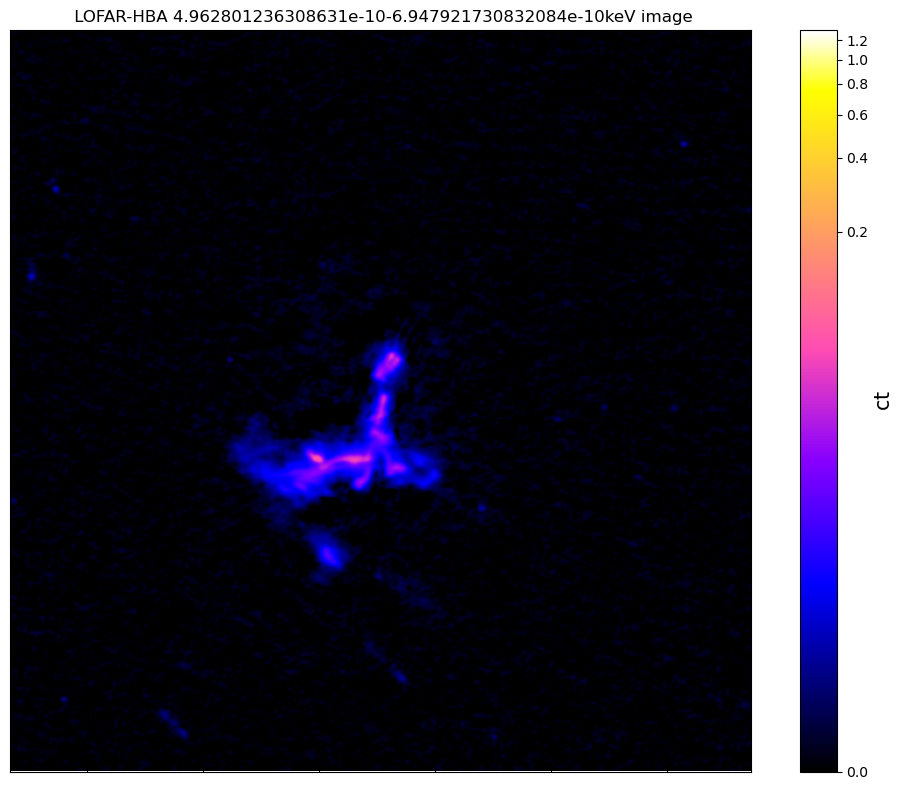

In [12]:
lov60_pix_coord = lof_im.coord_conv(lov60_coord, 'pix')
lov60_pix_rad = physical_rad_to_pix(lof_im, Quantity(0.94, 'Mpc'), lov60_coord, 0.1072, cosmo)

lov60_xlim = [(lov60_pix_coord[0] - lov60_pix_rad).value, (lov60_pix_coord[0] + lov60_pix_rad).value]
lov60_ylim = [(lov60_pix_coord[1] - lov60_pix_rad).value, (lov60_pix_coord[1] + lov60_pix_rad).value]

lof_im.view(manual_zoom_xlims=lov60_xlim, manual_zoom_ylims=lov60_ylim, zoom_in=True)

## LoVoCCS-South radio imaging

### IBIS-detected clusters

In [13]:
ibis_det_samp = obs_samp[obs_samp['LoVoCCS_name'].isin(ibis_det)]
ibis_det_samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes,sub_samp,LoVoCCS_name,ID,Name,RA,DEC,Redshift,Newly processed,Fully observed,Comments
5,MCXCJ0431.4-6126,J0431.4-6126,8,67.850417,-61.443889,0.0589,3.977333,4.5579,1.1485,RXCJ0431.4-6126,A3266,NaN,south,LoVoCCS-8,6,A3266,67.85,-61.44,0.0589,1.0,yes,NaN
7,MCXCJ0909.1-0939,J0909.1-0939,10,137.285000,-9.666111,0.0542,3.849660,4.4824,1.1439,RXCJ0909.1-0939,A754,NaN,south,LoVoCCS-10,8,A754,137.28,-9.67,0.0542,1.0,yes,"2 peaks in RS galaxy density map, lensing peak..."
48,MCXCJ1326.9-2710,J1326.9-2710,64,201.725000,-27.183333,0.0458,1.667482,2.7065,0.9694,RXCJ1326.9-2710,A1736,L,south,LoVoCCS-64,49,A1736,201.73,-27.18,0.0458,NaN,yes,NaN


The read operation timed out


The read operation timed out


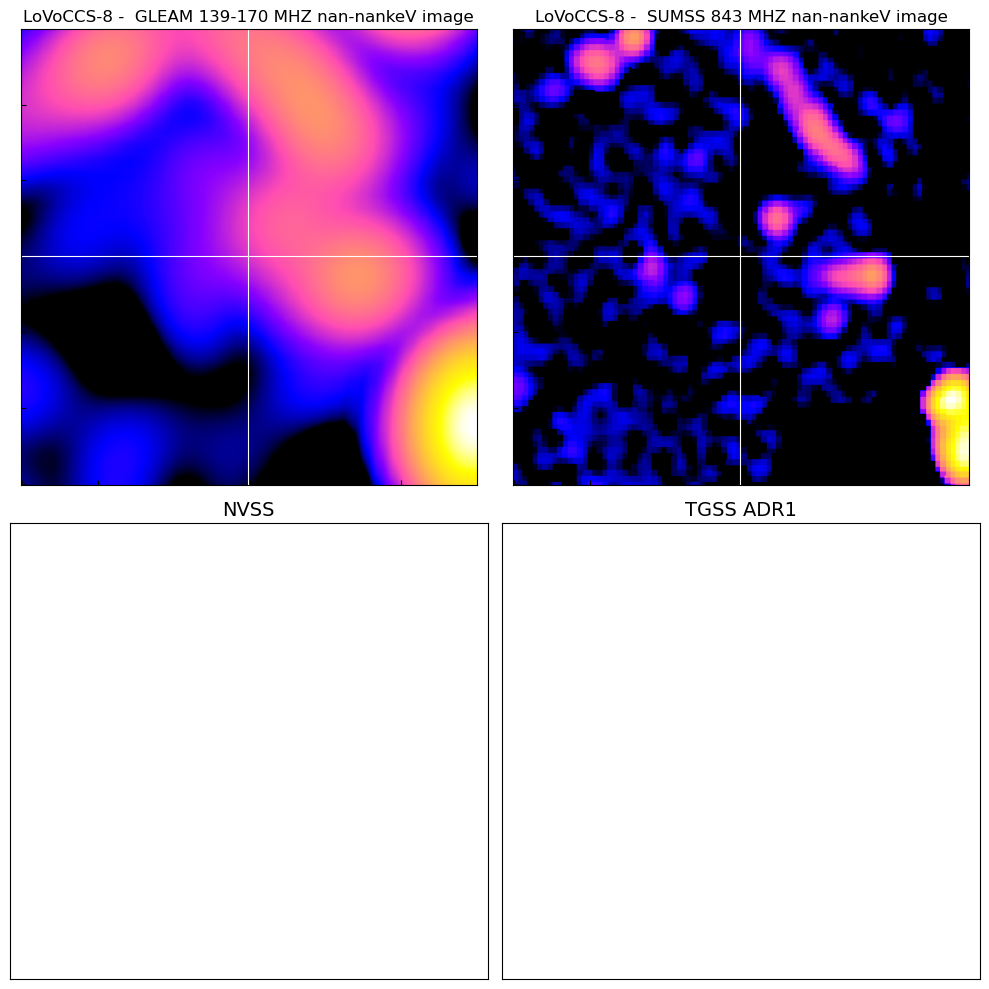

The read operation timed out


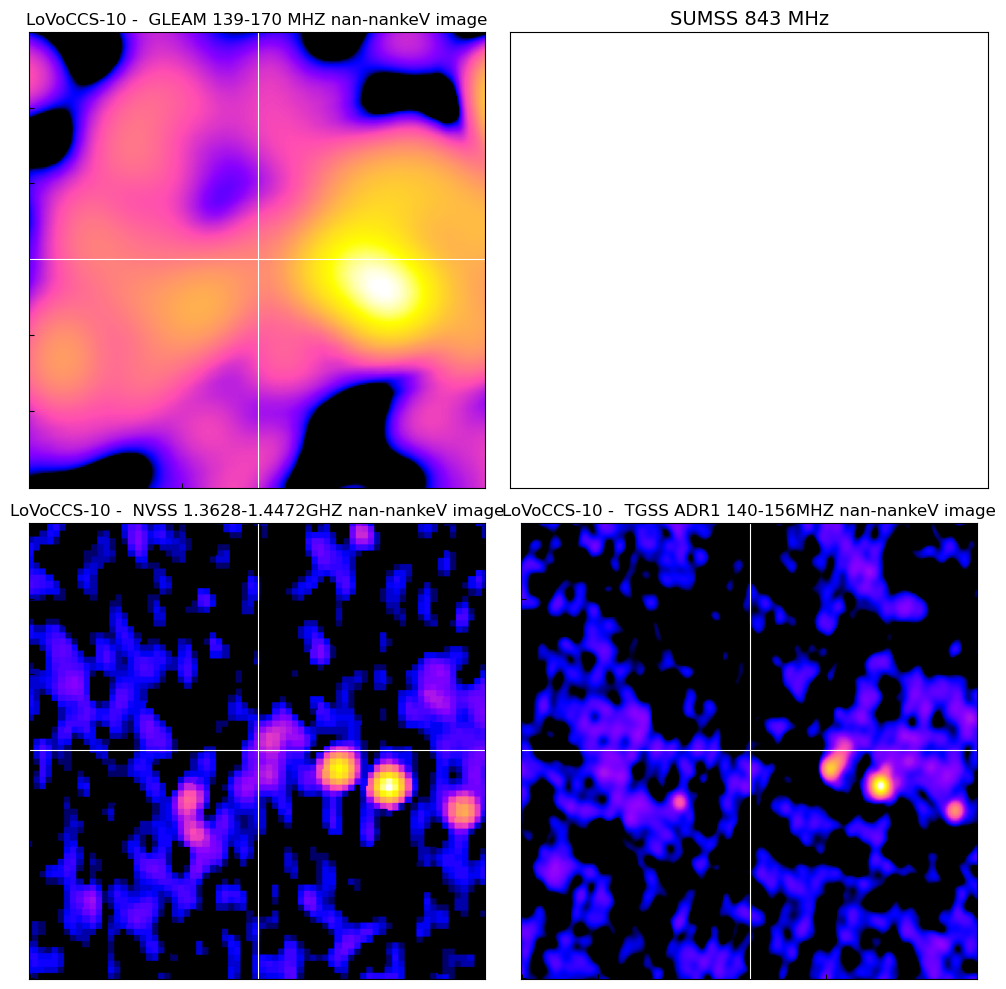

The read operation timed out


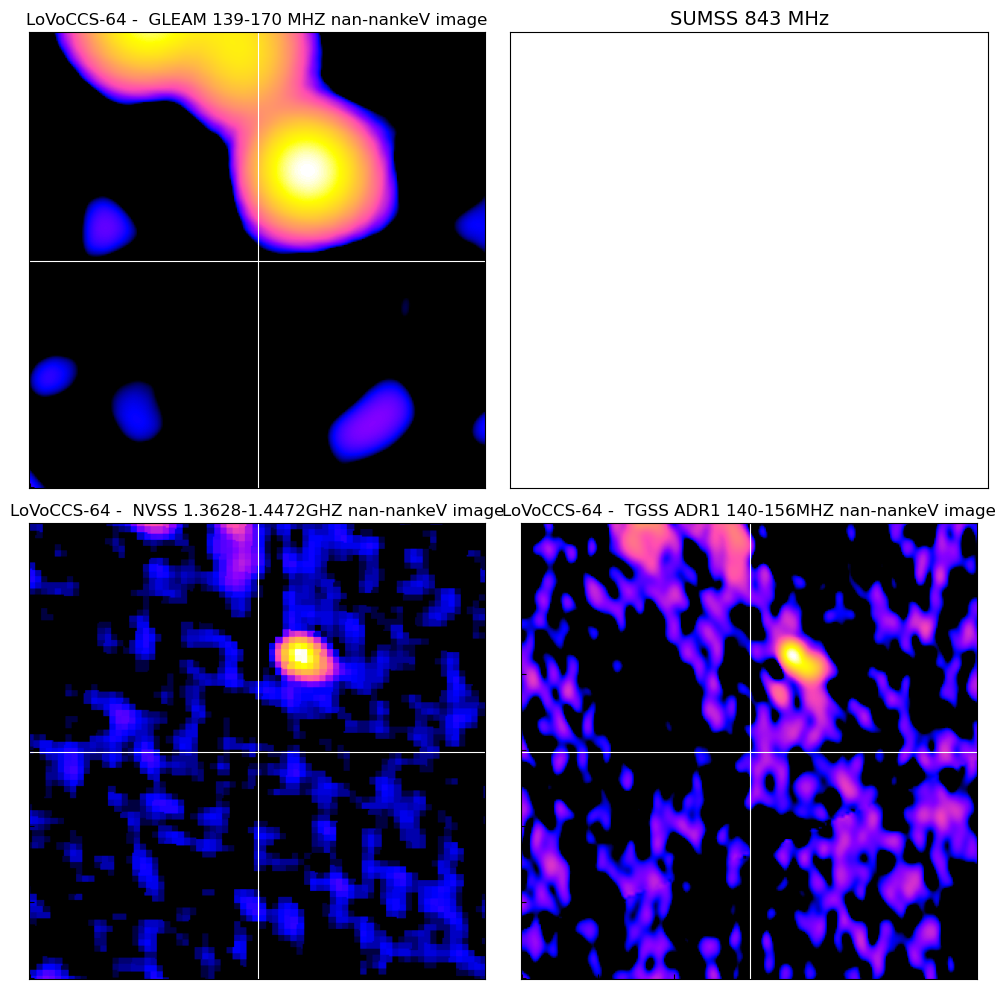

In [14]:
radio_coverage(ibis_det_samp, 'Downloading radio for IBIS detections')